# Benchmarking Pipeline: Compare Baseline vs DWF Model
This notebook compares a fixed-incentive strategy against the DWF RL model using cancellation rate, incentives, and profitability.

In [13]:
# Load Libraries
import gymnasium as gym
from gymnasium import Env, spaces
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import VecNormalize
from scipy.special import expit
import os

In [14]:
train_df = pd.read_csv("datasets/train_split.csv")
val_df =  pd.read_csv("datasets/val_split.csv")

In [ ]:
class RideHailingEnv_DWF(Env):
    def __init__(self, df):
        super(RideHailingEnv_DWF, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.episode_limit = 1000
        self.episode_start = 0

        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-0.15, 0.0]),
            high=np.array([0.15, 5.0]),
            dtype=np.float32
        )

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = np.random.randint(0, len(self.df) - self.episode_limit)
        self.episode_start = self.current_idx
        return self._get_observation(), {}

    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = np.round(action, 2)
        t_i = row['Request to Pickup']
        base_fare = row.get('Base Fare', 10.0)

        # --- Behavior-based cancellation modeling
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)

        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)
        delta = 0.2 * base_fare
        DPI = np.clip((rider_incentive + fare_adjustment * base_fare) / (t_i + 1e-5) + epsilon, 0.0, 1.0)

        cr_input = 0.75 * rank_percentile - 1.1 * RPI - 0.9 * DPI
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        reward = 4.0 if ride_completed else -4.0   # Increase absolute signal
        cost_penalty = (rider_incentive + abs(fare_adjustment) * delta) / (base_fare + 5)
        reward -= 0.8 * cost_penalty               # Reduce penalty scaling

        if rider_incentive > 3.0 or abs(fare_adjustment) > 0.12:
            reward -= 0.3                          # Softer soft-penalty

        reward = np.clip(reward, -8.0, 6.0)        # Wider positive range

        self.current_idx += 1
        done = False
        obs = self._get_observation()
        return obs, reward, done, False, {"CR": CR}

    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI'],
            row['CR'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


In [ ]:
# Baseline Model
class RideHailingEnv_Base(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def _get_observation(self):
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year']
        ], dtype=np.float32)


# RPI Model
class RideHailingEnv_RPI(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
    
    def _get_observation(self):
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI']
        ], dtype=np.float32)

# RPI_DPI Model
class RideHailingEnv_RPI_DPI(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)
    
    def _get_observation(self):
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI']
        ], dtype=np.float32)

# HDF Model
class RideHailingEnv_HDF(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
    
    def _get_observation(self):
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


In [17]:
def train_variant(env_cls, train_df, val_df, model_name):
    # Train environment
    train_env = DummyVecEnv([lambda: env_cls(train_df)])
    train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

    # Validation environment
    val_env = DummyVecEnv([lambda: env_cls(val_df)])
    val_env = VecNormalize(val_env, training=False, norm_obs=True, norm_reward=False)

    # Evaluation callback
    eval_callback = EvalCallback(
        val_env,
        best_model_save_path=f"./logs/{model_name}/",
        log_path=f"./logs/{model_name}/",
        eval_freq=5000,
        deterministic=True,
        render=False
    )

    model = PPO(
        "MlpPolicy",
        train_env,
        tensorboard_log=f"./ppo_tensorboard_logs/{model_name}/",
        learning_rate=4e-4,
        n_steps=2048,
        batch_size=256,
        gamma=0.98,
        gae_lambda=0.95,
        clip_range=0.4,
        ent_coef=0.01,
        vf_coef=0.4,
        max_grad_norm=0.5,
        policy_kwargs=dict(net_arch=[64, 64]),
        verbose=1,
        device="cuda"
    )

    model.learn(total_timesteps=200000, callback=eval_callback)
    model.save(f"models/{model_name}")
    train_env.save(f"models/{model_name}_vecnormalize.pkl")


In [18]:
train_variant(RideHailingEnv_Base, train_df, val_df, "model_base")

Using cuda device
Logging to ./ppo_tensorboard_logs/model_base/PPO_2


c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 363  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 339         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017746821 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.4         |
|    entropy_loss         | -2.85       |
|    explained_variance   | -1.18       |
|    learning_rate        | 0.0004      |
|    loss                 | 0.0414      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00636    |
|    std                  | 1.01        |
|    value_loss           | 0.313       |
----------------------------------

c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=575.58 +/- 173.67
Episode length: 1001.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | 576         |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.013516211 |
|    clip_fraction        | 0.00981     |
|    clip_range           | 0.4         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.0517      |
|    learning_rate        | 0.0004      |
|    loss                 | 0.0258      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00439    |
|    std                  | 1.01        |
|    value_loss           | 0.155       |
-----------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 228  |

In [19]:
train_variant(RideHailingEnv_RPI, train_df, val_df, "model_rpi")

Using cuda device
Logging to ./ppo_tensorboard_logs/model_rpi/PPO_1
-----------------------------
| time/              |      |
|    fps             | 360  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 335        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01755374 |
|    clip_fraction        | 0.0227     |
|    clip_range           | 0.4        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.352     |
|    learning_rate        | 0.0004     |
|    loss                 | 0.056      |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0081    |
|    std                  | 1          |
|    value_loss          

In [20]:
train_variant(RideHailingEnv_RPI_DPI, train_df, val_df, "model_rpi_dpi")

Using cuda device
Logging to ./ppo_tensorboard_logs/model_rpi_dpi/PPO_1
-----------------------------
| time/              |      |
|    fps             | 353  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015441262 |
|    clip_fraction        | 0.014       |
|    clip_range           | 0.4         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.255      |
|    learning_rate        | 0.0004      |
|    loss                 | 0.0177      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00649    |
|    std                  | 1           |
|   

In [21]:
train_variant(RideHailingEnv_HDF, train_df, val_df, "model_hdf")

Using cuda device
Logging to ./ppo_tensorboard_logs/model_hdf/PPO_1
-----------------------------
| time/              |      |
|    fps             | 352  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 336         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013849928 |
|    clip_fraction        | 0.00688     |
|    clip_range           | 0.4         |
|    entropy_loss         | -2.82       |
|    explained_variance   | -0.193      |
|    learning_rate        | 0.0004      |
|    loss                 | 0.0826      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00521    |
|    std                  | 0.987       |
|    val

Benchmarking

In [28]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

def evaluate_model(model_path, vecnormalize_path, env_class, test_df):
    # Create test env with Monitor to support VecNormalize
    env = DummyVecEnv([lambda: Monitor(env_class(test_df))])

    # Load VecNormalize wrapper with correct environment
    vec_norm = VecNormalize.load(vecnormalize_path, env)
    vec_norm.training = False
    vec_norm.norm_reward = False

    # ✅ Load the PPO model
    model = PPO.load(model_path)

    obs = vec_norm.reset()
    total_cost = 0
    completed_rides = 0
    total_cr = 0
    num_steps = 0

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_norm.step(action)

        cr = info[0].get("CR", 0.5)
        total_cr += cr
        if cr < 0.5:
            completed_rides += 1

        fare_adjustment, rider_incentive = action[0]
        base_fare = test_df.iloc[num_steps].get("Base Fare", 10.0)
        delta = 0.2 * base_fare
        cost = rider_incentive + abs(fare_adjustment) * delta
        total_cost += cost

        num_steps += 1
        if num_steps >= len(test_df) or done:
            break

    avg_cr = total_cr / num_steps
    avg_cost = total_cost / num_steps
    completion_rate = completed_rides / num_steps

    return {
        "avg_cost": avg_cost,
        "completion_rate": completion_rate,
        "avg_cr": avg_cr,
        "total_steps": num_steps
    }


In [24]:
test_df = pd.read_csv("datasets/test_split.csv")

In [ ]:
results = {}

model_variants = {
    "Base": ("models/model_base.zip", "models/model_base_vecnormalize.pkl", RideHailingEnv_Base),
    "RPI": ("models/model_rpi.zip", "models/model_rpi_vecnormalize.pkl", RideHailingEnv_RPI),
    "RPI+DPI": ("models/model_rpi_dpi.zip", "models/model_rpi_dpi_vecnormalize.pkl", RideHailingEnv_RPI_DPI),
    "HDF": ("models/model_hdf.zip", "models/model_hdf_vecnormalize.pkl", RideHailingEnv_HDF),
    "DWF": ("models/dwf_model.zip", "models/dwf_vecnormalize.pkl", RideHailingEnv_DWF)
}

for name, (model_path, vecnorm_path, env_class) in model_variants.items():
    results[name] = evaluate_model(model_path, vecnorm_path, env_class, test_df)


c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


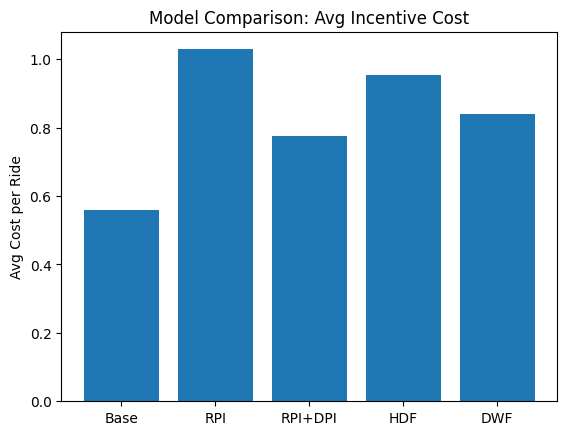

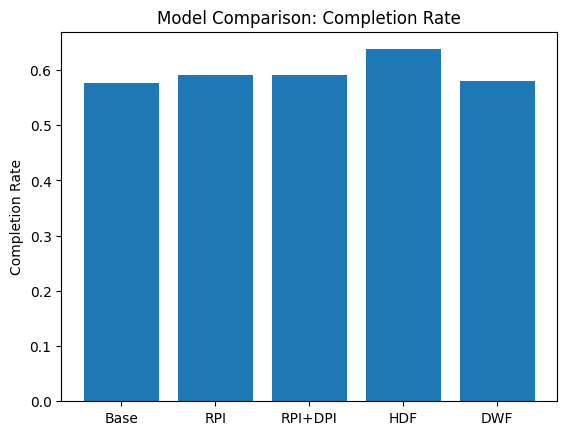

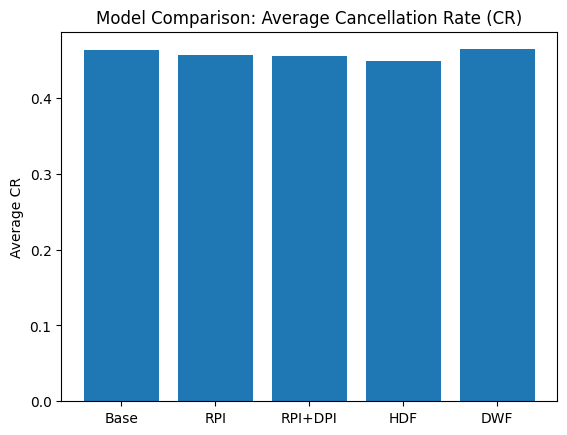

In [32]:
import matplotlib.pyplot as plt

labels = list(results.keys())
avg_costs = [results[k]["avg_cost"] for k in labels]
completion_rates = [results[k]["completion_rate"] for k in labels]
cancel_rates = [results[k]["avg_cr"] for k in labels]

# Plot Cost
plt.figure()
plt.bar(labels, avg_costs)
plt.ylabel("Avg Cost per Ride")
plt.title("Model Comparison: Avg Incentive Cost")
plt.show()

# Plot Completion Rate
plt.figure()
plt.bar(labels, completion_rates)
plt.ylabel("Completion Rate")
plt.title("Model Comparison: Completion Rate")
plt.show()

# Plot Cancellation Rate
plt.figure()
plt.bar(labels, cancel_rates)
plt.ylabel("Average CR")
plt.title("Model Comparison: Average Cancellation Rate (CR)")
plt.show()
